In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Based on Emotion of player identify the event using time stamp and extract the event's occurance using transition time before the event as x-y and transition time after the event as x+y and extract the video as highlight

1.METHOD

IMPORTING LIBRARIES

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

HYPERPARAMETRERS AND DIRECTORIES


In [5]:
train_dir = "/content/drive/MyDrive/archive (1)/train"
test_dir = "/content/drive/MyDrive/archive (1)/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 3
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['goal','happy', 'loss']
CLASS_LABELS_EMOJIS = ["🥅" , "😊" , "😔" ]

DATA LOADING AND PRE-PROCESSING

In [6]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 493 images belonging to 3 classes.
Found 122 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


Images with different emotions

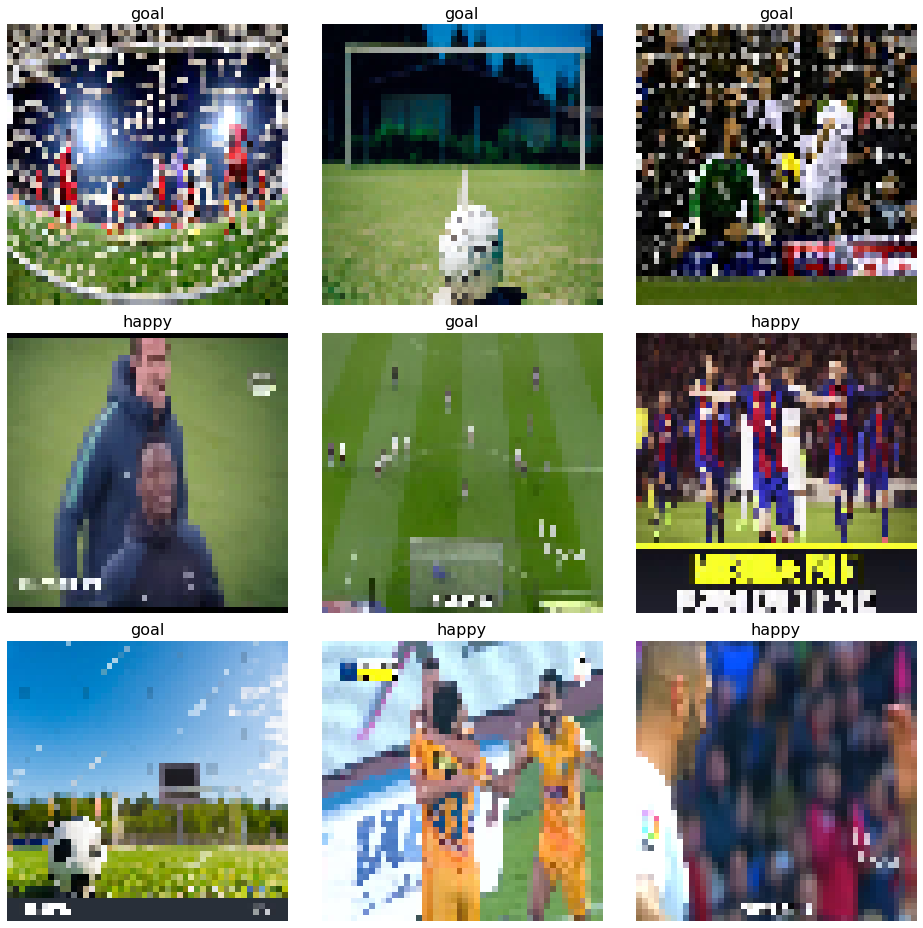

In [7]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

Data distribution (count) among differnt emotions

In [8]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

DenseNet169 Transfer Learning

In [9]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

Summary of model

In [10]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

Training and Fine-Tuning

Training model with freezed layers of DenseNer169

In [11]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
8/8 [==============================] - 191s 21s/step - loss: 16.3654 - accuracy: 0.4118 - val_loss: 18.7153 - val_accuracy: 0.3852
Epoch 2/30
8/8 [==============================] - 11s 1s/step - loss: 15.6007 - accuracy: 0.5132 - val_loss: 55.3290 - val_accuracy: 0.3852
Epoch 3/30
8/8 [==============================] - 11s 1s/step - loss: 15.0372 - accuracy: 0.6085 - val_loss: 15.5245 - val_accuracy: 0.3852
Epoch 4/30
8/8 [==============================] - 11s 1s/step - loss: 14.5042 - accuracy: 0.6369 - val_loss: 15.9402 - val_accuracy: 0.3852
Epoch 5/30
8/8 [==============================] - 11s 1s/step - loss: 13.9579 - accuracy: 0.6734 - val_loss: 14.9081 - val_accuracy: 0.3852
Epoch 6/30
8/8 [==============================] - 11s 1s/step - loss: 13.5281 - accuracy: 0.6613 - val_loss: 15.3720 - val_accuracy: 0.3852
Epoch 7/30
8/8 [==============================] - 11s 1s/step - loss: 13.0454 - accuracy: 0.7160 - val_loss: 13.7655 - val_accuracy: 0.3852
Epoch 8/30
8/8 [==

Fine Tuning

In [12]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/20
8/8 [==============================] - 27s 2s/step - loss: 7.2185 - accuracy: 0.9797 - val_loss: 8.4339 - val_accuracy: 0.3852
Epoch 2/20
8/8 [==============================] - 11s 1s/step - loss: 7.2073 - accuracy: 0.9899 - val_loss: 8.3509 - val_accuracy: 0.3852
Epoch 3/20
8/8 [==============================] - 11s 1s/step - loss: 7.2284 - accuracy: 0.9777 - val_loss: 8.2990 - val_accuracy: 0.3852
Epoch 4/20
8/8 [==============================] - 11s 1s/step - loss: 7.2503 - accuracy: 0.9615 - val_loss: 8.2778 - val_accuracy: 0.3852
Epoch 5/20
8/8 [==============================] - 12s 2s/step - loss: 7.2257 - accuracy: 0.9696 - val_loss: 8.2465 - val_accuracy: 0.3934
Epoch 6/20
8/8 [==============================] - 14s 2s/step - loss: 7.2101 - accuracy: 0.9817 - val_loss: 8.2232 - val_accuracy: 0.4262
Epoch 7/20
8/8 [==============================] - 17s 2s/step - loss: 7.2248 - accuracy: 0.9696 - val_loss: 8.2074 - val_accuracy: 0.4508
Epoch 8/20
8/8 [==================

Training plots

Multiclass AUC Curve

ROC AUC score: 0.5080902777777777


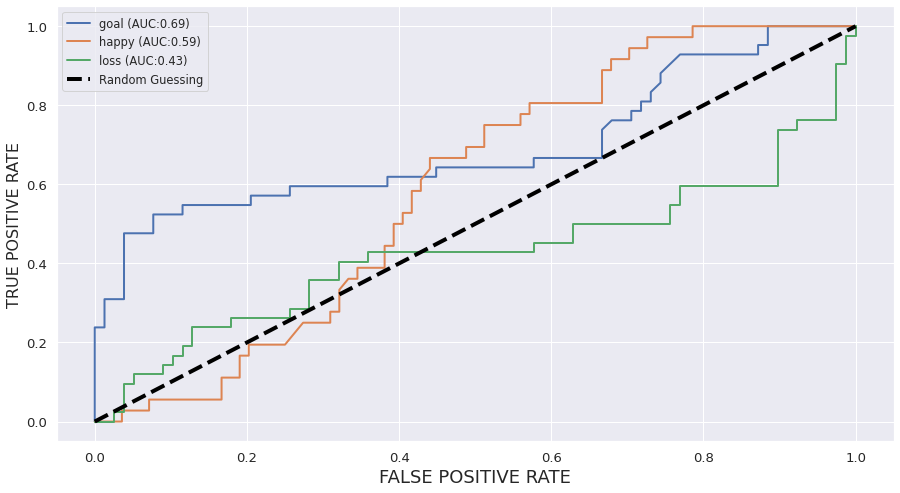

In [18]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [19]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.5697412155745489


2.METHOD

In [20]:
!pip install deepface
from deepface import DeepFace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.9 MB/s 
     |████████████████████████████████| 88 kB 4.8 MB/s 
     |████████████████████████████████| 2.3 MB 66.5 MB/s 
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=4e229fab8f060e264f417e52f9b9895d636e635554bb2f54c633a6363c7ecb3e
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire
Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [21]:
video_path = "/content/drive/MyDrive/archive (1)/train"

In [22]:
import cv2

In [23]:
face_model =cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_frontalface_default.xml")

In [24]:
frame_list = []

In [25]:
capture = cv2.VideoCapture(video_path)

In [26]:
from google.colab.patches import cv2_imshow

In [27]:

for i in range(5000) :
   _, frame = capture.read()
   face = face_model.detectMultiScale(cv2.imread(frame, cv2.COLOR_BGR2GRAY),1.1,5)
   
   for x, y, width, height in face:

    emotion = DeepFace.analyze(frame,actions=["emotion"])
     
    cv2.putText(frame,str(emotion["dominant_emotion"]),
                 (x, y + height),cv2.FONT_HERSHEY_COMPLEX,
                 0.9,
                 (255,255,0),2)
    cv2.rectangle(frame, (x,y),(x+ width, y + height),(0,255,0),3)
     
    frame_list.append(frame)

    height, width, colors = frame.shape
    size = (width ,height)
               

In [28]:
output_path = "/content/drive/MyDrive/archive (1)/Emotions.avi"

output= cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*"DIVX"),10,(640,480))

for frame in range(len(frame_list)):
    output.write(frame_list[frame])


output.release()


3.METHOD

In [29]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import img_to_array, load_img
from keras.losses import categorical_crossentropy

In [31]:
imgs_path = '/content/drive/MyDrive/archive (1)/train'
imgs_model_width, imgs_model_height = 224, 224

In [32]:
# pre trained model 

base_model = MobileNet( input_shape=(224,224,3), include_top= False )

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=3 , activation='softmax' )(x)

# custom model.
model = Model(base_model.input, x)
model.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

17225924/17225924 [==============================] - 0s 0us/step


In [33]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2, 
     shear_range = 0.2, 
     horizontal_flip=True, 
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/drive/MyDrive/archive (1)/train", 
                                               target_size=(224,224), 
                                               batch_size=32,
                                  )


train_data.class_indices

Found 615 images belonging to 3 classes.


{'goal': 0, 'happy': 1, 'loss': 2}

In [34]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "/content/drive/MyDrive/archive (1)/test", 
                                           target_size=(224,224), 
                                           batch_size=32,
                                  )

Found 120 images belonging to 3 classes.


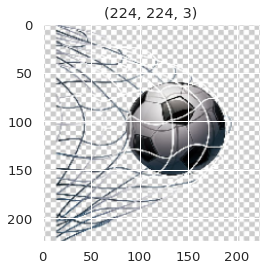

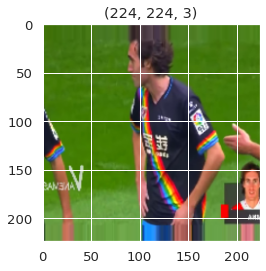

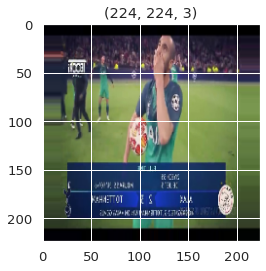

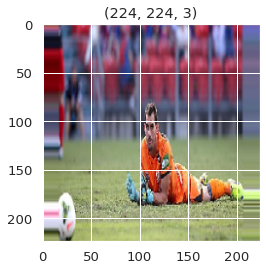

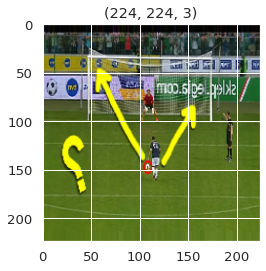

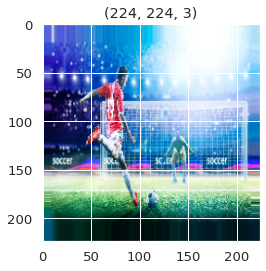

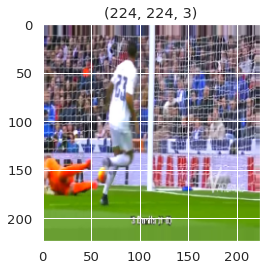

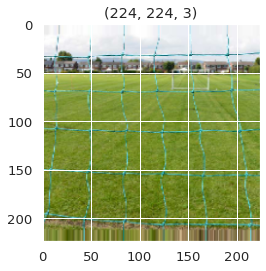

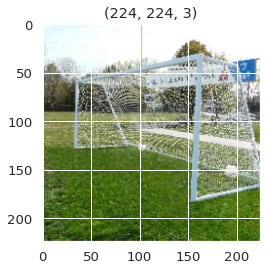

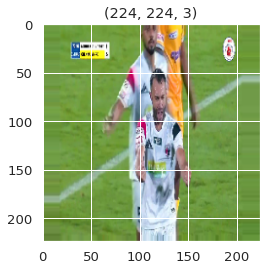

In [35]:
# the images in the training data denerator 

t_img , label = train_data.next()

#-----------------------------------------------------------------------------
# plot the images 
def plotImages(img_arr, label):
  """
  input  :- images array 
  output :- plots the images 
  """
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    
    count += 1
    if count == 10:
      break

#-----------------------------------------------------------------------------
# plot the images 
plotImages(t_img, label)

In [36]:
#early stopping and model check point 

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# call back in a list 
call_back = [es, mc]
print(str(es))

In [37]:
hist = model.fit_generator(train_data, 
                           steps_per_epoch= 10, 
                           epochs= 30, 
                           validation_data= val_data, 
                           validation_steps= 8, 
                           callbacks=[es,mc])

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 6.1875 - accuracy: 0.5797
Epoch 1: val_accuracy improved from -inf to 0.55833, saving model to best_model.h5
10/10 [==============================] - 19s 2s/step - loss: 6.1875 - accuracy: 0.5797 - val_loss: 6.7099 - val_accuracy: 0.5583
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 2.9050 - accuracy: 0.7458
Epoch 3/30
10/10 [==============================] - 7s 746ms/step - loss: 2.8053 - accuracy: 0.7627
Epoch 4/30
10/10 [==============================] - 8s 795ms/step - loss: 1.5746 - accuracy: 0.8313
Epoch 5/30
10/10 [==============================] - 8s 854ms/step - loss: 1.2568 - accuracy: 0.8542
Epoch 6/30
10/10 [==============================] - 13s 1s/step - loss: 1.4092 - accuracy: 0.8219
Epoch 7/30
10/10 [==============================] - 11s 1s/step - loss: 1.1542 - accuracy: 0.8644
Epoch 8/30
10/10 [==============================] - 17s 2s/step - loss: 0.5660 - accuracy: 0.9250
Ep

In [38]:
# o/p values 
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))
op

{0: 'goal', 1: 'happy', 2: 'loss'}

1/1 [==============================] - 1s 634ms/step
 the image is of goal


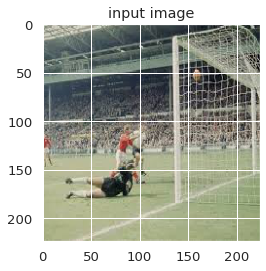

In [39]:
#Prediction
path = "/content/drive/MyDrive/archive(1)/test/pic-112.jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image  
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

In [41]:
!pip install --trusted-host pypi.python.org moviepy
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.2 MB/s 


In [44]:
output_path = "/content/drive/MyDrive/archive (1)/Emotions.mp4"

output= cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*"DIVX"),10,(640,480))

for frame in range(len(frame_list)):
    output.write(frame_list[frame])


output.release()